<a href="https://colab.research.google.com/github/a01137646/NA_Proyecto_Final_Equipo21/blob/main/Proyecto_Final_Equipo21_borrador2_udacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import glob


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, MaxPooling2D

In [2]:
datadir = './Documents/GitHub/NA_Proyecto_Final_Equipo21/DATA/'
list_folders = glob.glob(datadir + '*')

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.DataFrame()
for path in list_folders:
  data_temp = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
  data = pd.concat([data,data_temp], ignore_index=True)

#del(data_temp)
print('Cantidad de registros:',len(data.index))
data.head()

Cantidad de registros: 9103


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\G\Downloads\simulator-windows-64\DATA...,C:\Users\G\Downloads\simulator-windows-64\DAT...,C:\Users\G\Downloads\simulator-windows-64\DAT...,0.0,0.000000,0,0.000082
1,C:\Users\G\Downloads\simulator-windows-64\DATA...,C:\Users\G\Downloads\simulator-windows-64\DAT...,C:\Users\G\Downloads\simulator-windows-64\DAT...,0.0,0.000000,0,0.000083
2,C:\Users\G\Downloads\simulator-windows-64\DATA...,C:\Users\G\Downloads\simulator-windows-64\DAT...,C:\Users\G\Downloads\simulator-windows-64\DAT...,0.0,0.000000,0,0.000082
3,C:\Users\G\Downloads\simulator-windows-64\DATA...,C:\Users\G\Downloads\simulator-windows-64\DAT...,C:\Users\G\Downloads\simulator-windows-64\DAT...,0.0,0.127203,0,0.054509
4,C:\Users\G\Downloads\simulator-windows-64\DATA...,C:\Users\G\Downloads\simulator-windows-64\DAT...,C:\Users\G\Downloads\simulator-windows-64\DAT...,0.0,0.427562,0,0.410255


In [3]:
def path_leaf(path):
    return '/'.join(path.split('\\')[-3:])

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,LAP 1/IMG/center_2023_06_09_12_53_24_129.jpg,LAP 1/IMG/left_2023_06_09_12_53_24_129.jpg,LAP 1/IMG/right_2023_06_09_12_53_24_129.jpg,0.0,0.000000,0,0.000082
1,LAP 1/IMG/center_2023_06_09_12_53_24_234.jpg,LAP 1/IMG/left_2023_06_09_12_53_24_234.jpg,LAP 1/IMG/right_2023_06_09_12_53_24_234.jpg,0.0,0.000000,0,0.000083
2,LAP 1/IMG/center_2023_06_09_12_53_24_336.jpg,LAP 1/IMG/left_2023_06_09_12_53_24_336.jpg,LAP 1/IMG/right_2023_06_09_12_53_24_336.jpg,0.0,0.000000,0,0.000082
3,LAP 1/IMG/center_2023_06_09_12_53_24_442.jpg,LAP 1/IMG/left_2023_06_09_12_53_24_442.jpg,LAP 1/IMG/right_2023_06_09_12_53_24_442.jpg,0.0,0.127203,0,0.054509
4,LAP 1/IMG/center_2023_06_09_12_53_24_542.jpg,LAP 1/IMG/left_2023_06_09_12_53_24_542.jpg,LAP 1/IMG/right_2023_06_09_12_53_24_542.jpg,0.0,0.427562,0,0.410255


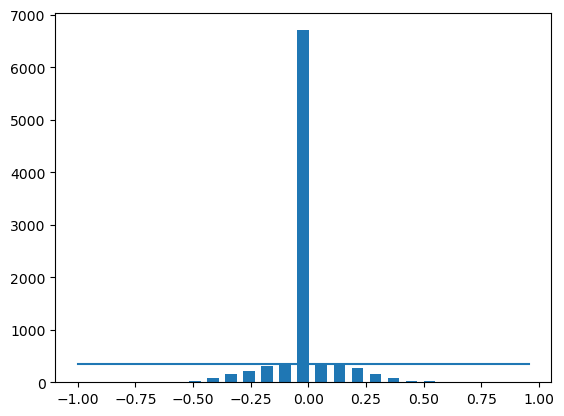

In [4]:
num_bins = 25

samples_per_bin = 350

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 9103


In [ ]:
#print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        #center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        center = indexed_data[0]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        #image_path.append(os.path.join(datadir,left.strip()))
        #steering.append(float(indexed_data[3])+0.15)
        # right image append
        #image_path.append(os.path.join(datadir,right.strip()))
        #steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir, data)

In [ ]:
def img_perspective(image, steering, orientation, angle, multiplier):
    height,width, ch = image.shape

    if orientation == 'left':
      pts1 = np.float32([[0,0],[0,height],[width,height-height*angle],[width,height*angle]])
      pts2 = np.float32([[0,0],[0,height],[width,height],[width,0]])
      steering = steering - angle*multiplier
    else:
      pts1 = np.float32([[0,height*angle],[0,height-height*angle],[width,height],[width,0]])
      pts2 = np.float32([[0,0],[0,height],[width,height],[width,0]])
      steering = steering + angle*multiplier
    M = cv2.getPerspectiveTransform(pts1,pts2)
    image = cv2.warpPerspective(image,M,(width,height))
    return image, steering

def img_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [ ]:
image_paths_temp = list(image_paths)
steerings_temp = list(steerings)

for i in range(len(image_paths)):
  img = mpimg.imread(image_paths[i])
  rand1 = random.randrange(20, 35)/100
  img_left_1, steering_left_1 = img_perspective(img,steerings[i],'left',rand1,1.5)
  img_right_1, steering_right_1 = img_perspective(img,steerings[i],'right',rand1,1.5)
  path_left_1 = image_paths[i][:-4]+'_left_1'+image_paths[i][-4:]
  path_right_1 = image_paths[i][:-4]+'_right_1'+image_paths[i][-4:]
  mpimg.imsave(path_left_1,img_left_1); image_paths_temp.append(path_left_1); steerings_temp.append(steering_left_1)
  mpimg.imsave(path_right_1,img_right_1); image_paths_temp.append(path_right_1); steerings_temp.append(steering_right_1)
  rand2 = random.randrange(35, 45)/100
  img_left_2, steering_left_2 = img_perspective(img,steerings[i],'left',rand2,2)
  img_right_2, steering_right_2 = img_perspective(img,steerings[i],'right',rand2,2)
  path_left_2 = image_paths[i][:-4]+'_left_2'+image_paths[i][-4:]
  path_right_2 = image_paths[i][:-4]+'_right_2'+image_paths[i][-4:]
  mpimg.imsave(path_left_2,img_left_2); image_paths_temp.append(path_left_2); steerings_temp.append(steering_left_2)
  mpimg.imsave(path_right_2,img_right_2); image_paths_temp.append(path_right_2); steerings_temp.append(steering_right_2)

length = len(image_paths_temp)
for i in range(length):
  if steerings_temp[i] != 0:
    img_path = image_paths_temp[i]
    img = mpimg.imread(img_path)
    img, new_steering = img_flip(img,steerings_temp[i])
    new_path = img_path[:-4]+'_flipped'+img_path[-4:]
    mpimg.imsave(new_path,img)
    image_paths_temp.append(new_path); steerings_temp.append(new_steering)

image_paths = np.array(image_paths_temp)
steerings = np.array(steerings_temp)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.25))
    image = zoom.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [ ]:
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [ ]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 0.5))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [ ]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle


ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [ ]:
def img_preprocess(img):
    img = img[60:135,:,:]
    #brightness = iaa.Multiply(1.5)
    #img = brightness.augment_image(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255

    return img

image = image_paths[300]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img =[]
        batch_steering = []

        for i in range(batch_size):

            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
def nvidia_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 24, kernel_size = (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 36, kernel_size = (5, 5), strides=(2, 2), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 48, kernel_size = (5, 5), strides=(2, 2), activation='elu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='elu'))

#filters = 32, kernel_size = (3, 3),
#                     input_shape = tensor_X_train.shape[1:],
#                     activation='relu', padding='same'

    model.add(tf.keras.layers.Convolution2D(filters = 64, kernel_size = (3, 3), activation='elu'))
    # model.add(tf.keras.layers.Dropout(0.5))


    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(100, activation = 'elu'))

    model.add(tf.keras.layers.Dense(50, activation = 'elu'))


    model.add(tf.keras.layers.Dense(10, activation = 'elu'))


    model.add(tf.keras.layers.Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
model = nvidia_model()
model.summary()

In [ ]:
batch_size = 200

history = model.fit(batch_generator(X_train, y_train, batch_size, 1),
                              steps_per_epoch=300,
                              epochs=7,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1,
                              shuffle = 1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('./Documents/GitHub/NA_Proyecto_Final_Equipo21/model.h5')

In [ ]:
import socketio
import eventlet
import numpy as np
from flask import Flask
from keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2

In [ ]:
sio = socketio.Server()

app = Flask(__name__) #'__main__'
speed_limit = 40
def img_preprocess(img):
    img = img[60:135,:,:]
    #brightness = iaa.Multiply(1.5)
    #img = brightness.augment_image(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    #img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
    #brightness = iaa.Multiply((0.5, 0.5))
    #img = brightness.augment_image(img)
    #img = cv2.GaussianBlur(img,(3,3),0,0)
    #img = cv2.resize(img, (200, 66))
    #img = img/255
    return img

In [ ]:
@sio.on('telemetry')
def telemetry(sid, data):
    #print(np.asarray(Image.open(BytesIO(base64.b64decode(data['image'])))))
    speed = float(data['speed'])
    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = img_preprocess(image)
    image = np.array([image])
    steering_angle = float(model.predict(image,verbose = 0))
    throttle = 1.0 - speed/speed_limit
    #print('{} {} {}'.format(steering_angle, throttle, speed))
    send_control(steering_angle, throttle)

In [ ]:
@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    send_control(0, 0)

def send_control(steering_angle, throttle):
    sio.emit('steer', data = {
        'steering_angle': steering_angle.__str__(),
        'throttle': throttle.__str__()
    })

In [ ]:
if __name__ == '__main__':
    model = load_model('./Documents/GitHub/NA_Proyecto_Final_Equipo21/model.h5')
    app = socketio.Middleware(sio, app)
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)